In [133]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Diabetic_clear (100).jpg
/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Myopia_clear (78).jpg
/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Normal_clear (64).jpg
/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Myopia_clear (59).jpg
/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Normal_clear (80).jpg
/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Normal_clear (33).jpg
/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Myopia_clear (48).jpg
/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Normal_clear (16).jpg
/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Myopia_clear (53).jpg
/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Myopia_clear (82).jpg
/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Diabetic_clear (2).jpg
/kaggle/input/faz

In [134]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [135]:
image_dir="/kaggle/input/faz-training2/faz-training-data/pre-processed_images"
mask_dir="/kaggle/input/faz-training2/faz-training-data/pre-processed_masks"

In [136]:
class FAZDataset (Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir=image_dir
        self.mask_dir=mask_dir
        self.transform=transform
        self.images=sorted(os.listdir(image_dir))
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        img_path=os.path.join(self.image_dir, self.images[idx])
        mask_name=self.images[idx].replace(".jpg", "_mask.png")
        mask_path=os.path.join(self.mask_dir, mask_name)
        image=np.array(Image.open(img_path).convert("RGB"))
        mask=np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask=mask/255.0
        if self.transform:
            augmented=self.transform(image=image, mask=mask)
            image=augmented['image']
            mask=augmented['mask'].unsqueeze(0)
        return image, mask

In [137]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5), 
    
    A.RandomRotate90(p=0.6),

    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.05, rotate_limit=15, 
        border_mode=0, p=0.5
    ),

    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
        A.CLAHE(clip_limit=2.0),
        A.GaussianBlur(blur_limit=3)
    ], p=0.3), 

    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


In [138]:
from torch.utils.data import DataLoader

# 2. Create dataset instance
train_dataset = FAZDataset(
    image_dir="/kaggle/input/faz-training2/faz-training-data/pre-processed_images",
    mask_dir="/kaggle/input/faz-training2/faz-training-data/pre-processed_masks",
    transform=train_transform
)

# 3. Load into DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [139]:
dataset = FAZDataset(image_dir, mask_dir, transform=train_transform)

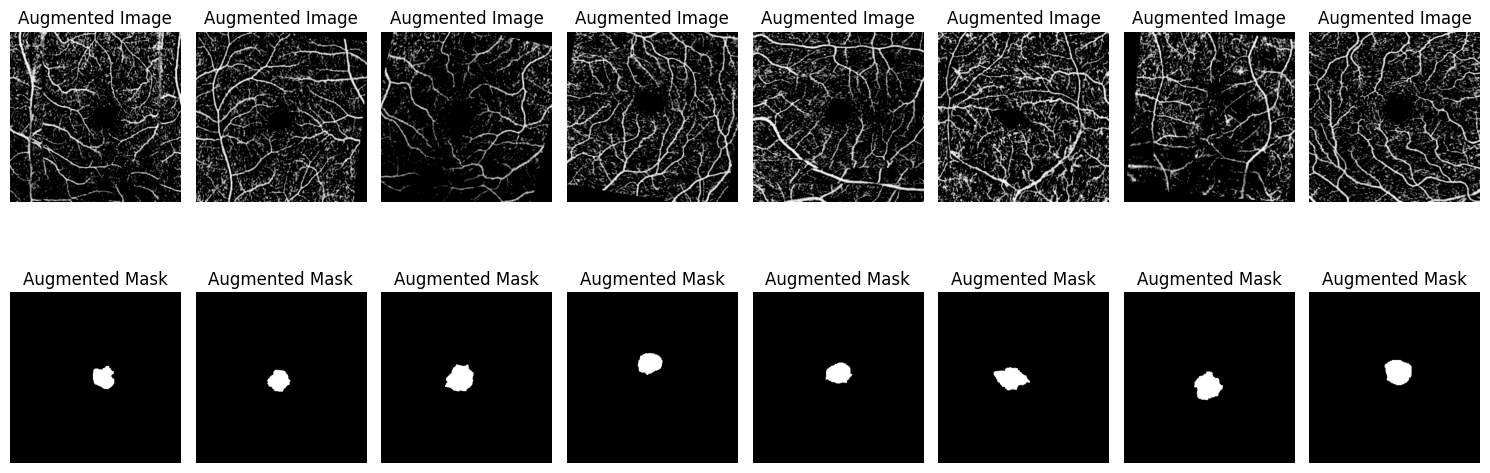

In [140]:
import random
import matplotlib.pyplot as plt
image_dir = "/kaggle/input/faz-training2/faz-training-data/pre-processed_images"
mask_dir = "/kaggle/input/faz-training2/faz-training-data/pre-processed_masks"


# Pick N random samples from your dataset
sample_indices = random.sample(range(len(os.listdir(image_dir))), 8)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    
    image_name = os.listdir(image_dir)[idx]
    image_path = os.path.join(image_dir, image_name)
    mask_name = image_name.replace(".jpg", "_mask.png")
    mask_path = os.path.join(mask_dir, mask_name)

    
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))

    
    augmented = train_transform(image=image, mask=mask)
    aug_img = augmented["image"].permute(1, 2, 0).numpy()
    aug_mask = augmented["mask"].squeeze().numpy()

    
    plt.subplot(2, len(sample_indices), i+1)
    plt.imshow(aug_img, cmap='gray')
    plt.title("Augmented Image")
    plt.axis('off')

    plt.subplot(2, len(sample_indices), i+1+len(sample_indices))
    plt.imshow(aug_mask, cmap='gray')
    plt.title("Augmented Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [141]:
import torch.nn as nn

In [142]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [143]:
model=smp.Unet(
    encoder_name='densenet121',
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

In [144]:
from torchvision import models

In [145]:
#denseNet121 as encoder
class DenseEncoder(nn.Module):
    def __init__(self):
        super(DenseEncoder, self).__init__()
        densenet = models.densenet121(pretrained=True)

       
        self.initial = densenet.features[0]          
        self.pool = densenet.features[1]             
        self.dense_block1 = densenet.features[2]     
        self.trans1 = densenet.features[3]           
        self.dense_block2 = densenet.features[4]     
        self.trans2 = densenet.features[5]           
        self.dense_block3 = densenet.features[6]      
        self.trans3 = densenet.features[7]            
        self.dense_block4 = densenet.features[8]      
        self.norm5 = densenet.features[9]             

    def forward(self, x):
        x0 = self.initial(x)         
        x1 = self.pool(x0)           
        x2 = self.dense_block1(x1)   
        x3 = self.trans1(x2)         
        x4 = self.dense_block2(x3)   
        x5 = self.trans2(x4)         
        x6 = self.dense_block3(x5)   
        x7 = self.trans3(x6)         
        x8 = self.dense_block4(x7)   
        x9 = self.norm5(x8)          

        return [x0, x2, x4, x6, x9]  

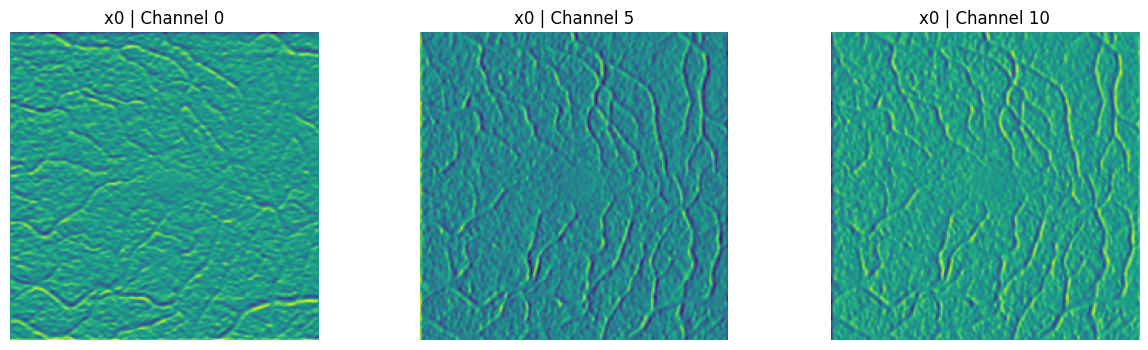

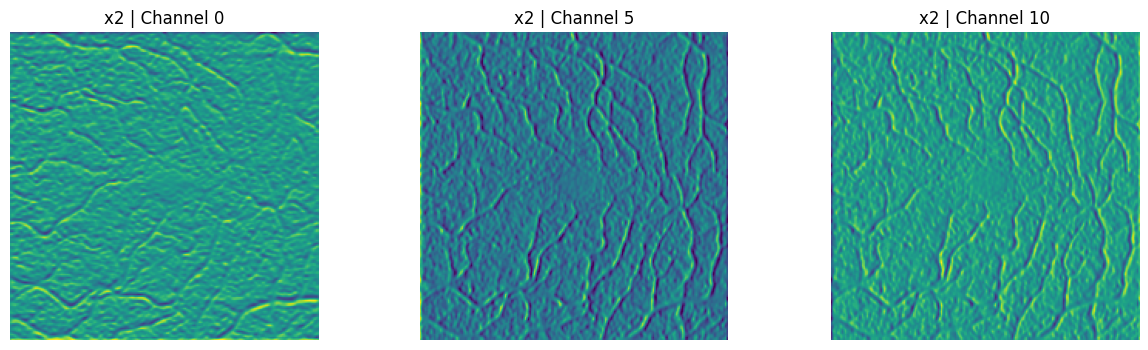

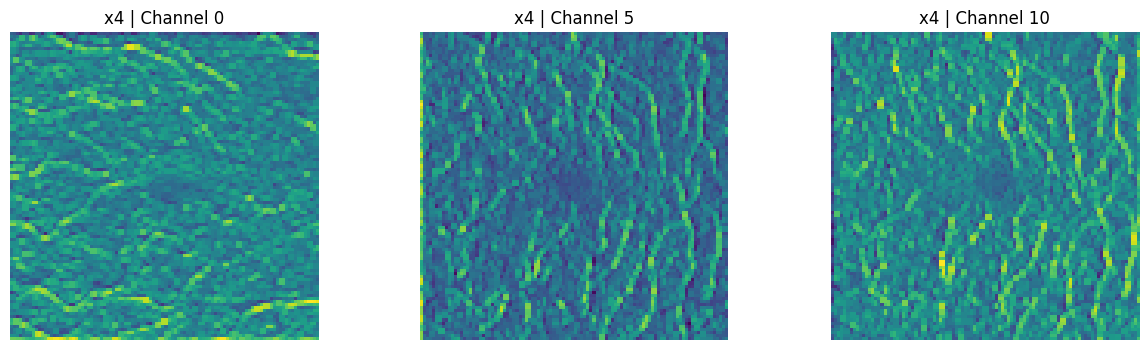

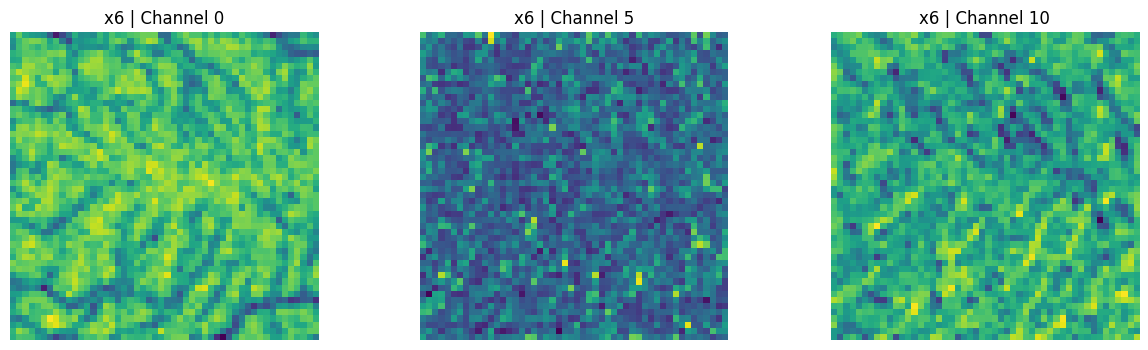

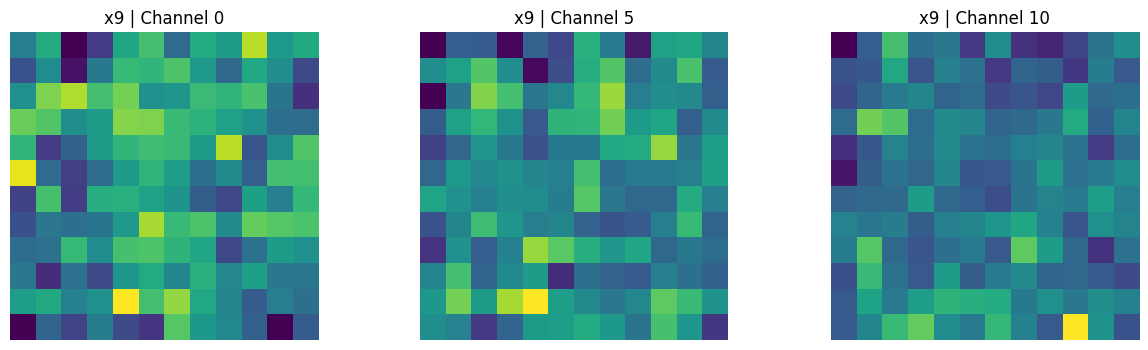

In [146]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

# 1. Load an image and preprocess
image_path = "/kaggle/input/faz-training2/faz-training-data/pre-processed_images/Diabetic_clear (1).jpg"

# Apply same preprocessing used during training
transform = T.Compose([
    T.Resize((400, 400)),
    T.ToTensor()
])

img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0)  # Shape: [1, 3, H, W]

# 2. Pass image through encoder
encoder = DenseEncoder()
encoder.eval()
with torch.no_grad():
    features = encoder(img_tensor)

# 3. Visualize a few channels from each output stage
def visualize_feature_map(feature_map, title, channels=[0, 5, 10]):
    plt.figure(figsize=(15, 4))
    for i, ch in enumerate(channels):
        plt.subplot(1, len(channels), i+1)
        plt.imshow(feature_map[0, ch].cpu(), cmap='viridis')
        plt.title(f"{title} | Channel {ch}")
        plt.axis('off')
    plt.show()

# Loop over selected encoder outputs
layer_names = ['x0', 'x2', 'x4', 'x6', 'x9']
for name, fmap in zip(layer_names, features):
    visualize_feature_map(fmap, title=name)


In [147]:
import torch.nn.functional as F

In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12)
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18)
        
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        self.final = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)

        x5 = self.global_pool(x)
        x5 = F.interpolate(x5, size=x.shape[2:], mode='bilinear', align_corners=False)

        x_cat = torch.cat([x1, x2, x3, x4, x5], dim=1)
        return self.final(x_cat)



In [149]:
class SCSEBlock(nn.Module):
    def __init__(self, in_channels):
        super(SCSEBlock, self).__init__()

        # Channel Squeeze and Excitation
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),             # Global avg pool
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

        # Spatial Squeeze and Excitation
        self.sSE = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        cse_out = self.cSE(x) * x
        sse_out = self.sSE(x) * x
        return cse_out + sse_out


In [150]:
import torch.nn.functional as F

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()

        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)

        self.scse = SCSEBlock(out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)                             # Upsample decoder features
        if skip is not None:
            x = torch.cat([x, skip], dim=1)             # Concatenate with skip connection
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.scse(x)                                # Apply SCSE attention
        return x


In [151]:
class UNetDecoder(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super(UNetDecoder, self).__init__()

        # We'll build 4 decoder blocks (excluding enc0, which is the original input size)
        self.blocks = nn.ModuleList([
            DecoderBlock(encoder_channels[4], encoder_channels[3], decoder_channels[0]),
            DecoderBlock(decoder_channels[0], encoder_channels[2], decoder_channels[1]),
            DecoderBlock(decoder_channels[1], encoder_channels[1], decoder_channels[2]),
            DecoderBlock(decoder_channels[2], encoder_channels[0], decoder_channels[3]),
        ])

    def forward(self, enc_features):
        x = enc_features[-1]  # Start from the deepest encoder output (enc4)

        for i, block in enumerate(self.blocks):
            skip = enc_features[3 - i] if i < len(enc_features) - 1 else None
            x = block(x, skip)

        return x  # final decoder output


In [152]:
class SegmentationHead(nn.Module):
    def __init__(self, in_channels, out_channels=1, kernel_size=3):
        super(SegmentationHead, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2
        )

    def forward(self, x):
        return self.conv(x)


In [153]:
class FAZUNet(nn.Module):
    def __init__(self):
        super(FAZUNet, self).__init__()

        # 1. Encoder (DenseNet121)
        backbone = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT).features
        self.enc0 = nn.Sequential(backbone[0], backbone[1])   # Conv + BN + ReLU
        self.enc1 = nn.Sequential(backbone[2])                # MaxPool
        self.enc2 = backbone[3]                               # DenseBlock1
        self.enc3 = backbone[4]                               # Transition1 + DenseBlock2
        self.enc4 = backbone[5]                               # Transition2 + DenseBlock3

        # 2. ASPP
        self.aspp = ASPP(in_channels=128, out_channels=256)

        # 3. Decoder
        encoder_channels = [64, 256, 512, 1024, 1024]  # last 1024 after ASPP
        decoder_channels = [256, 128, 64, 32]
        self.decoder = UNetDecoder(encoder_channels, decoder_channels)

        # 4. Final head
        self.segmentation_head = SegmentationHead(in_channels=decoder_channels[-1], out_channels=1)

    def forward(self, x):
        # Encoder
        e0 = self.enc0(x)
        e1 = self.enc1(e0)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        print("✅ Shape before ASPP:", e4.shape)

        # ASPP on deepest encoder output
        bottleneck = self.aspp(e4)

        # Decoder
        features = [e0, e1, e2, e3, bottleneck]
        d = self.decoder(features)

        # Final segmentation map
        out = self.segmentation_head(d)
        return out


In [154]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        logits = torch.sigmoid(logits)  # since we use BCEWithLogits
        logits = logits.view(-1)
        targets = targets.view(-1)

        intersection = (logits * targets).sum()
        dice = (2. * intersection + self.smooth) / (logits.sum() + targets.sum() + self.smooth)
        return 1 - dice  # Dice Loss


In [155]:
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

def combined_loss(logits, targets):
    return bce_loss(logits, targets) + dice_loss(logits, targets)


In [156]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [157]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FAZUNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [158]:
def dice_score(logits, targets, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    
    intersection = (preds * targets).sum()
    return (2. * intersection) / (preds.sum() + targets.sum() + 1e-8)


In [159]:
import torch.nn as nn

# Dice Loss implementation
def dice_loss(pred, target, smooth=1e-5):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

# Combined BCE + Dice Loss
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()  # expects raw logits

    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        d_loss = dice_loss(probs, targets)
        return bce + d_loss


In [160]:
from torch.utils.data import DataLoader

# Paths to your preprocessed images and masks
image_dir = "/kaggle/input/faz-training2/faz-training-data/pre-processed_images"

mask_dir = "/kaggle/input/faz-training2/faz-training-data/pre-processed_masks"

# Dataset instance
dataset = FAZDataset(image_dir, mask_dir, transform=train_transform)

# DataLoader
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Get one batch
batch = next(iter(loader))
images, masks = batch  # shapes: [B, 3, H, W], [B, 1, H, W]


In [161]:
from torch.utils.data import DataLoader

# 1. Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# 2. Get a batch
images, masks = next(iter(train_loader))

print("✅ Batch shapes:")
print("Images:", images.shape)  # [B, 3, H, W]
print("Masks:", masks.shape)    # [B, 1, H, W]


✅ Batch shapes:
Images: torch.Size([4, 3, 400, 400])
Masks: torch.Size([4, 1, 400, 400])


In [162]:
# Move to device
images = images.to(device)
masks = masks.to(device)

# Forward pass
outputs = model(images)

# Calculate individual losses
bce = bce_loss(outputs, masks)
dice = dice_loss(outputs, masks)
total_loss = bce + dice  # (You can add shape loss later)

print(f"🔍 BCE Loss:  {bce.item():.4f}")
print(f"🔍 Dice Loss: {dice.item():.4f}")
print(f"✅ Total Loss: {total_loss.item():.4f}")


✅ Shape before ASPP: torch.Size([4, 128, 50, 50])


RuntimeError: Given transposed=1, weight of size [1024, 256, 2, 2], expected input[4, 256, 50, 50] to have 1024 channels, but got 256 channels instead

In [ ]:
import matplotlib.pyplot as plt

# Take 1st sample in the batch
pred_mask = outputs[0][0].detach().cpu().numpy()
true_mask = masks[0][0].cpu().numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("🔹 Ground Truth")
plt.imshow(true_mask, cmap='gray')
plt.subplot(1,2,2)
plt.title("🔸 Predicted")
plt.imshow(pred_mask > 0.5, cmap='gray')  # Thresholded
plt.show()
